In [1]:
%load_ext rpy2.ipython

from rpy2.robjects.packages import importr
import numpy as np
import pandas as pd
from chromax import Simulator
import tensorflow as tf
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.animation import ArtistAnimation
import matplotlib.gridspec as gridspec
from tqdm import tqdm
import io
from PIL import Image
import imageio
import os
os.environ["KERAS_BACKEND"] = "jax"
import matplotlib


2023-12-30 12:38:28.619420: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:

def plot_means_and_variances(dataframes):
    # Calculate the mean and variance for each dataframe
    mean_values = [df.mean() for df in dataframes]
    var_values = [df.var() for df in dataframes]
    var_values = np.array(var_values).flatten()
    mean_values = np.array(mean_values).flatten()

    # Create an array for the x-values
    x_values = range(len(dataframes))

    # Create the scatter plot with error bars
    plt.errorbar(x_values, mean_values, yerr=var_values, fmt='o')

    # Display the plot
    plt.show()


def generate_genetic_map(n_markers, n_chromosomes):
  df = pd.DataFrame(generate_marker_effects(n_markers=n_markers), columns=['Yield'])
  df['cM'] = np.random.uniform(0, 200, len(df))
  df['CHR.PHYS'] = '1A'
  df = df.sort_values(by='cM')
  df = df[['CHR.PHYS', 'cM', 'Yield']]
  # save df as csv under filename
  return df

def generate_population(n_pop=100, n_markers=500):
    """
    Generate a numpy array of randoms of length 500 with randomized 0, 1, or 2 at each position.
    It will generate 100 individuals based on n_pop.

    Returns: numpy array of size (n_pop, n_markers)
    """
    shape=(n_pop, n_markers, 2)
    # Define the elements to choose from and their associated probabilities
    elements = [0, 1, 2]
    probabilities = [1/3, 1/3, 1/3]  # equal probabilities for 0, 1, and 2

    # Generate the population
    population = np.random.choice(elements, size=(n_pop, n_markers), p=probabilities)

    return np.random.choice([True, False], size=shape)


def generate_marker_effects(n_markers=500, mu=0, sigma=0.1):
    """
    Generate a numpy array of marker effects with a normal distribution.

    Parameters:
    n_markers (int): Number of markers.
    mu (float): Mean of the distribution.
    sigma (float): Standard deviation of the distribution.

    Returns:
    numpy array of marker effects
    """

    # Generate the marker effects
    marker_effects = np.random.normal(mu, sigma, n_markers)

    return marker_effects


def select_random_individuals(arr, num_individuals):
    # Get the shape of the array
    shape = arr.shape

    # Generate random indices along the first axis
    idx = np.random.choice(shape[0], size=num_individuals)

    # Select the random individuals

    return random_individuals

def select_mixed(population, random_split=.99):
  n_pop = population.shape[0]

  n_random = int(n_pop * random_split)
  n_select = int(n_pop * (1-random_split))

  random_parents = select_random_individuals(Farm.current_population, n_random)
  selected_parents = Farm.Simulator.select(Farm.current_population, k = n_select)
  combined_arr = np.concatenate((random_parents, selected_parents), axis=0)
  return combined_arr

def plot_replicate_means_and_variances(replicate_data, start_index=None, end_index=None):
    # Create a new figure and axes
    fig, ax = plt.subplots()

    # If start_index or end_index is not provided, set them to default values
    if start_index is None:
        start_index = 0
    if end_index is None:
        end_index = len(replicate_data[0])

    # For each list of dataframes in replicate_data
    for i, dataframes in enumerate(replicate_data):
        # Select the dataframes in the specified range
        dataframes = dataframes[start_index:end_index]

        # Calculate the mean and variance for each dataframe
        mean_values = [df.mean() for df in dataframes]
        var_values = [df.var() for df in dataframes]

        # Flatten the var_values and mean_values lists to 1D arrays
        var_values = np.array(var_values).flatten()
        mean_values = np.array(mean_values).flatten()

        # Create an array for the x-values
        x_values = range(len(dataframes))

        # Plot the means with error bars for the variances
        ax.errorbar(x_values, mean_values, yerr=var_values, fmt='o', label=f'Replicate {i+1}')

    # Add a legend
    ax.legend()

    # Display the plot
    plt.show()


def plot_replicate_means(replicate_data):
    # Create a new figure and axes
    fig, ax = plt.subplots()

    # For each list of dataframes in replicate_data
    for i, dataframes in enumerate(replicate_data):
        # Calculate the mean for each dataframe
        mean_values = [df.mean() for df in dataframes]
        # Flatten the mean_values list to a 1D array
        mean_values = np.array(mean_values).flatten()

        # Create an array for the x-values
        x_values = range(len(dataframes))

        # Plot the means as a line plot
        ax.plot(x_values, mean_values, label=f'Replicate {i+1}')

    # Add a legend
    ax.legend()

    # Display the plot
    plt.show()

def parse_markerEffects(genetic_map, nChr):
    # Get the length of the genetic map
    length = len(genetic_map)

    # Create a new array for storing the chromosome number for each marker
    chr = [0] * length

    # Calculate the number of markers per chromosome
    markers_per_chr = length // nChr

    # Iterate over the range of the genetic map length
    for i in range(length):
        # Calculate the chromosome number and store it in the chr array
        chr[i] = i // markers_per_chr + 1

    return chr

def score_top(scores: pd.DataFrame, column: str, k: int):
    # Sort the DataFrame from high to low
    sorted_scores = scores.sort_values(by=column, ascending=False)
    # Get the top K indexes
    top_k_indexes = sorted_scores.head(k).index
    return top_k_indexes


def score_top_percentile(scores: pd.DataFrame, column: str, percentile_min: float, percentile_max: float, k: int):
    # Ensure max percentile is greater than min percentile
    assert percentile_max > percentile_min, "Error: max percentile should be greater than min percentile"
    
    # Calculate the percentiles
    lower = scores[column].quantile(percentile_min)
    upper = scores[column].quantile(percentile_max)
    # Filter the DataFrame
    filtered_scores = scores[(scores[column] >= lower) & (scores[column] <= upper)]
    # Sample k random indexes
    sampled_indexes = np.random.choice(filtered_scores.index, k, replace=True)

    return sampled_indexes

def reshape_pop(maizeHaplo):
    reshapeHaplo = maizeHaplo.reshape(int((maizeHaplo.shape[0])/2),2,maizeHaplo.shape[1])
    reshapeHaplo = reshapeHaplo.transpose((0,2,1))
    return reshapeHaplo

def return_genetic_map_df(markerEffects, nChr, geneticMap):
    chr = parse_markerEffects(markerEffects, nChr)
    chr = [int(x[0]) for x in chr]
    trait = markerEffects
    pos = geneticMap
    # Assuming chr, trait, pos are your arrays
    df = pd.DataFrame({'CHR.PHYS': chr, 'Yield': trait, 'cM': pos})
    return df

import matplotlib.pyplot as plt

def plot_histogram(ax, probabilities, label=None, color=None):
    ax.hist(probabilities, bins='auto', density=True, alpha=0.5, label=label, color=color)
    ax.set_title('Probability Distribution')
    ax.set_xlabel('Probability')
    ax.set_ylabel('Frequency')

def plot_bar(ax, probabilities, label=None, color=None):
    indices = range(len(probabilities))
    ax.bar(indices, probabilities, alpha=0.5, label=label, color=color)
    ax.set_title('Probability per Index')
    ax.set_xlabel('Index')
    ax.set_ylabel('Probability')

def plot_probabilities(probabilities1, probabilities2):
    # Create subplots: 1 row, 2 columns
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Call the plot functions for the first set of probabilities
    plot_histogram(axs[0], probabilities1, label='Probabilities 1', color='blue')
    plot_bar(axs[1], probabilities1, label='Probabilities 1', color='blue')

    # Call the plot functions for the second set of probabilities
    plot_histogram(axs[0], probabilities2, label='Probabilities 2', color='red')
    plot_bar(axs[1], probabilities2, label='Probabilities 2', color='red')

    # Add legends
    axs[0].legend(loc='upper right')
    axs[1].legend(loc='upper right')

    # Display the plots
    plt.tight_layout()  # Adjusts subplot params so that subplots fit in the figure area
    plt.show()

def select_parent(probabilities):
    try:
        # Ensure probabilities sum up to 1
        probabilities = np.array(probabilities, dtype=np.float64)
        probabilities[-1] = max(0, 1 - np.sum(probabilities[:-1]))
        indices = np.arange(len(probabilities))  # Create an array of indices
        sampled_index = np.random.choice(indices, p=probabilities)  # Sample an index based on the probabilities
    except ValueError:
        print("Error: probabilities do not sum up to 1")
        print("Probabilities:", probabilities)
        raise
    return sampled_index



In [3]:
%%R
x <- seq(0, 2*pi, length.out=50)

In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages


In [4]:
%R -o x

In [5]:
x

array([0.        , 0.12822827, 0.25645654, 0.38468481, 0.51291309,
       0.64114136, 0.76936963, 0.8975979 , 1.02582617, 1.15405444,
       1.28228272, 1.41051099, 1.53873926, 1.66696753, 1.7951958 ,
       1.92342407, 2.05165235, 2.17988062, 2.30810889, 2.43633716,
       2.56456543, 2.6927937 , 2.82102197, 2.94925025, 3.07747852,
       3.20570679, 3.33393506, 3.46216333, 3.5903916 , 3.71861988,
       3.84684815, 3.97507642, 4.10330469, 4.23153296, 4.35976123,
       4.48798951, 4.61621778, 4.74444605, 4.87267432, 5.00090259,
       5.12913086, 5.25735913, 5.38558741, 5.51381568, 5.64204395,
       5.77027222, 5.89850049, 6.02672876, 6.15495704, 6.28318531])

In [6]:
# %R install.packages("AlphaSimR")

In [7]:
%%R
library("AlphaSimR")

Loading required package: R6


In [8]:
%%R
nInd = 50
nChr = 2
segSites = 20

founderGenomes = runMacs(nInd = nInd,
                         nChr = nChr,
                         segSites = segSites,
                         species = "MAIZE")


In [9]:
%%R
SP = SimParam$new(founderGenomes)
SP$addTraitA(segSites)
# SP$setVarE(h2=.02)
pop = newPop(founderGenomes, simParam=SP)
ans = fastRRBLUP(pop, simParam=SP, useQtl=TRUE, use='gv')
ans@gv[[1]]@addEff
markerEffects = slot(slot(ans, "gv")[[1]], "addEff")
maizeHaplo = pullSegSiteHaplo(pop)
maizeGeno = pullSegSiteGeno(pop)
#cm positions of each marker
genMap = SP$genMap
geneticMap = unlist(genMap)

In [10]:
%R -o maizeHaplo
%R -o maizeGeno
%R -o markerEffects
%R -o geneticMap
%R -o nInd
%R -o nChr
%R -o segSites

In [11]:
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, Flatten, Reshape

#create init population + genetic map
n = int(nInd)
m = int((segSites * nChr))
d = 2
total_parents = n*2 # pop size per cycle



def calculate_true_reward(simulator, current_population, new_population):
    true_reward = simulator.GEBV(new_population).mean() - simulator.GEBV(current_population).mean()
    return true_reward

def calculate_critic_loss(true_reward, critic_output):
    return (true_reward - critic_output)**2
    

def create_actor():
    # Define the actor model
    actor_input = keras.layers.Input(shape=(n, m, d))
    x = Flatten()(actor_input)
    x = Dense(64, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(n * total_parents, activation='linear')(x)
    x = Reshape((total_parents, n))(x)
    actor_output = keras.layers.Softmax(axis=-1)(x)
    actor_model = keras.models.Model(actor_input, actor_output)
    actor_model.compile(optimizer='adam', loss='categorical_crossentropy')
    return actor_model

def create_critic():
    # Define the critic model
    critic_input1 = keras.layers.Input(shape=(n, m, d))
    critic_input2 = keras.layers.Input(shape=(total_parents, n))

    x1 = Flatten()(critic_input1)
    x1 = Dense(64, activation='relu')(x1)

    x2 = Flatten()(critic_input2)
    x2 = Dense(64, activation='relu')(x2)

    combined = keras.layers.concatenate([x1, x2])

    x3 = Dense(64, activation='relu')(combined)
    critic_output = Dense(1, activation='linear')(x3)

    critic_model = keras.models.Model([critic_input1, critic_input2], critic_output)
    critic_model.compile(optimizer='adam', loss='mse')
    return critic_model


def calculate_actor_loss(actor_output, selected_array, advantages):
    actor_log_probs = tf.math.log(actor_output)
    selected_log_probs = tf.gather(actor_log_probs, selected_array, axis=1)
    loss = -tf.reduce_sum(selected_log_probs * advantages)
    return loss


@tf.function
def actor_train_step(actor_model, optimizer, loss, example_population, selected_array, advantages):
    with tf.GradientTape() as tape:
        predicted_actions = actor_model(example_population)
        actor_loss = loss(predicted_actions, selected_array, advantages)
    gradients = tape.gradient(actor_loss, actor_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, actor_model.trainable_variables))
    return actor_loss



@tf.function
def critic_train_step(critic_model, optimizer, example_population, actor_output, past_fitness):
    with tf.GradientTape() as tape:
        predicted_rewards = critic_model([ example_population, actor_output])
        critic_loss = (past_fitness - predicted_rewards) ** 2
    gradients = tape.gradient(critic_loss, critic_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, critic_model.trainable_variables))
    return critic_loss
import random

import random

def simplify_geneticmap(lst, qtl):
    # Select 'qtl' random indexes
    indexes_positive = random.sample(range(len(lst)), qtl)
    
    # Select 'qtl' random indexes not already selected
    remaining_indexes = set(range(len(lst))) - set(indexes_positive)
    indexes_negative = random.sample(remaining_indexes, qtl)

    # Modify the list
    for i in range(len(lst)):
        if i in indexes_positive:
            lst[i] = random.uniform(0.5, 1.0)  # Assign random float between 0.5 and 1.0
        elif i in indexes_negative:
            lst[i] = random.uniform(-0.5, -1.0)  # Assign random float between -0.5 and -1.0
        else:
            lst[i] = 0  # Assign 0

    return lst



import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def load_data(file_path):
    """
    Load the numpy array from the specified file path.
    """
    return np.load(file_path)

def sum_ploidy_values(data):
    """
    Sum the ploidy values in the data.
    """
    return np.sum(data, axis=2)

def create_heatmap(data, title="Heatmap of Ploidy Values", xlabel="Marker Index", ylabel="Individual Index"):
    """
    Create a heatmap from the provided data.
    """
    # Choosing a visually appealing color scheme
    cmap = sns.color_palette(["#1f77b4", "#ff7f0e", "#2ca02c"], as_cmap=True)

    plt.figure(figsize=(12, 10))
    ax = sns.heatmap(data, cmap=cmap, cbar=False)

    # Creating a color bar manually
    cbar = ax.figure.colorbar(ax.collections[0])
    cbar.set_ticks([0.33, 1, 1.67])
    cbar.set_ticklabels(['0', '1', '2'])
    cbar.set_label('Summed Ploidy Value')

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.show()

In [12]:
def plot_population_heatmap(ax, population_data, marker_strength):
    summed_data = np.sum(population_data, axis=2)
    cmap = sns.color_palette(["#1f77b4", "#ff7f0e", "#2ca02c"])
    strength_cmap = matplotlib.colormaps.get_cmap('RdYlGn')  # Updated line
    sns.heatmap(summed_data, cmap=cmap, cbar_kws={'ticks': [0, 1, 2]}, ax=ax)

    ax.set_xticks(np.arange(population_data.shape[1]) + 0.5)
    marker_labels = [f'{i+1}' for i in range(population_data.shape[1])]
    ax.set_xticklabels(marker_labels, rotation=0, ha='center')

    for tick_label, strength in zip(ax.get_xticklabels(), marker_strength):
        tick_label.set_backgroundcolor(strength_cmap((strength + 1) / 2))  # Normalize and map the strength value
        tick_label.set_color('white')
        tick_label.set_fontweight('bold')
        tick_label.set_bbox(dict(facecolor=strength_cmap((strength + 1) / 2), edgecolor='none', boxstyle='round,pad=0.3'))

    ax.set_title("Heatmap of Population Genotype Dosages")
    ax.set_xlabel("Markers")
    ax.set_ylabel("Individuals")

def plot_allele_frequencies(ax, data, marker_strength, sort_by_allele_0=False, bar_width=0.8):
    allele_counts = np.apply_along_axis(lambda x: np.bincount(x, minlength=3), axis=2, arr=data)
    total_allele_counts = allele_counts.sum(axis=0)
    allele_frequencies = total_allele_counts / total_allele_counts.sum(axis=1)[:, np.newaxis]

    allele_0_proportions = allele_frequencies[:, 0]
    allele_1_proportions = allele_frequencies[:, 1]
    x_positions = np.arange(1, len(allele_0_proportions) + 1)
    normalized_strength = (np.array(marker_strength) + 1) / 2

    cmap = plt.cm.RdYlGn

    if sort_by_allele_0:
        sorted_indices = np.argsort(-allele_0_proportions)
        allele_0_proportions = allele_0_proportions[sorted_indices]
        allele_1_proportions = allele_1_proportions[sorted_indices]
        normalized_strength = normalized_strength[sorted_indices]

    for xpos, a0, a1, strength in zip(x_positions, allele_0_proportions, allele_1_proportions, normalized_strength):
        ax.bar(xpos, a0, color='red', edgecolor='black', width=bar_width, label='Allele 0' if xpos == 1 else "")
        ax.bar(xpos, a1, bottom=a0, color='black', edgecolor='black', width=bar_width, label='Allele 1' if xpos == 1 else "")
        ax.text(xpos, -0.05, f'{xpos}', horizontalalignment='center', verticalalignment='center', 
                 color='white', fontsize=8, fontweight='bold', 
                 bbox=dict(facecolor=cmap(strength), edgecolor='none', boxstyle='round,pad=0.2'))

    ax.set_ylim(-0.15, 1)
    ax.set_ylabel('Proportion')
    ax.set_xlabel('Marker Position')
    ax.set_title('Proportion of Alleles 0 and 1 at Each Marker' + (' (Sorted by Allele 0)' if sort_by_allele_0 else ''))
    ax.legend(loc='upper right')

import tempfile
import os

def create_frame(farm, episode):
    temp_dir = farm.temp_dir
    fig = plt.figure(figsize=(10, 15))  # Adjust the figure size

    gs = gridspec.GridSpec(3, 1, figure=fig)

    ax1 = fig.add_subplot(gs[0])
    farm.view_policy(ax1, episode)

    ax2 = fig.add_subplot(gs[1])
    plot_population_heatmap(ax2, farm.current_population, farm.marker_strength)

    ax3 = fig.add_subplot(gs[2])
    plot_allele_frequencies(ax3, farm.current_population, farm.marker_strength)

    # Save the figure as a png in the temporary directory
    filename = os.path.join(temp_dir.name, f'frame_{episode}.png')
    plt.savefig(filename)
    plt.close(fig)  # Close the plot

    return filename  # Return the filename for future use



In [13]:
class BreedingProgram:
    """
    Represents a breeding program with a PPO agent.
    """

    def __init__(self, initial_population, genetic_map, population_size, marker_count, chromosome_number, max_generation, heritability):
        """
        Initializes the breeding program.
        """

        # Initialize the basic attributes
        self.population_size = population_size
        self.marker_count = marker_count
        self.initial_population = initial_population
        self.genetic_map = genetic_map
        self.max_generation = max_generation
        self.marker_strength = np.array(self.genetic_map['Yield'])

        # Initialize the simulator
        self.simulator = Simulator(genetic_map=self.genetic_map, h2=heritability)
        self.simulator.load_population('mypop.npy')

        #tempdir
        self.temp_dir = tempfile.TemporaryDirectory()


        # Initialize the current generation and history
        self.current_generation = 0
        self.history = []

        # Initialize the Actor and Critic models
        self.actor = create_actor()
        self.critic = create_critic()
        self.actor_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
        self.critic_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
        self.critic_history = []
        self.actor_history = []

                # Start the breeding program
        self._start_breeding_program()
        
    def _start_breeding_program(self):
        """
        Starts the breeding program.
        """
        self.current_population = self.initial_population
        self.current_scores = self.simulator.GEBV(self.initial_population)
        self.history.append(self.current_scores)
 
    def run_episodes(self, num_episodes, num_cycles):
        frames = []
        for i in range(num_episodes):
            img = create_frame(self, i)
            frames.append(img)
            self.current_population = self.initial_population
            for cycle_iter in range(num_cycles):
                current_pop = self.current_population.reshape(1, *self.current_population.shape)
                actor_output = self.actor(current_pop)
                critic_output = self.critic([current_pop, actor_output])
                action_selections = [select_parent(x) for x in actor_output[0, :, :]]
                selected_array = np.array([action_selections[i:i+2] for i in range(0, len(action_selections), 2)])

                new_population = self.simulator.cross(current_pop[0][selected_array])
                future_rewards = self.simulator.GEBV(new_population).mean()[0]
                advantages = future_rewards - critic_output.numpy()[0][0]

                actor_loss = actor_train_step(self.actor, self.actor_optimizer, calculate_actor_loss, current_pop, selected_array, advantages)
                critic_loss = critic_train_step(self.critic, self.critic_optimizer, current_pop, actor_output, past_fitness=future_rewards)

                mean_score_list.append(self.simulator.GEBV(self.current_population).mean()[0])
                self.critic_history.append(critic_loss.numpy()[0][0])
                self.actor_history.append(actor_loss)

                self.current_population = np.array(new_population)
                self.current_scores = self.simulator.GEBV(self.current_population)
                self.history.append(self.current_scores)

                if cycle_iter == (num_cycles-1):
                    print(f'episode {i} : actor loss - {actor_loss} /// critic loss - {critic_loss}')

        return frames

    def view_policy(self, ax, episode):
        current_pop = self.current_population.reshape(1,*self.current_population.shape)
        policy = self.actor(current_pop)
        sns.heatmap(policy[0], ax=ax)
        ax.set_xlabel('Individual ID')
        ax.set_ylabel('Parent Slot ID')
        ax.annotate('Episode: {}'.format(episode), xy=(0.5, 1.05), xycoords='axes fraction', fontsize=12, ha='center')






initial_population =  reshape_pop(maizeHaplo) 
genetic_map = return_genetic_map_df(markerEffects, nChr, geneticMap)
genetic_map['Yield'] = simplify_geneticmap(list(genetic_map['Yield']),5)
reshapeHaplo = reshape_pop(maizeHaplo)
np.save('mypop', reshapeHaplo)
print(f'reshape haplo {reshapeHaplo.shape}')
population_size = int(nInd)
marker_count = int((segSites * nChr))
chromosome_number = int(nChr)
max_generation = 10
heritability = .95
mean_score_list=[]
critic_loss_list=[]

farm  = BreedingProgram(initial_population, genetic_map, population_size, marker_count, chromosome_number, max_generation, heritability)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


reshape haplo (50, 40, 2)


In [50]:
def truncate_cycle(farm):
    nInd = farm.current_population.shape[0]
    top5 = farm.simulator.select(farm.current_population,k=nInd // 2)
    new_pop = farm.simulator.random_crosses(top5,n_crosses=nInd)
    farm.history.append(farm.simulator.GEBV(new_pop))
    farm.current_population = new_pop

In [56]:
for i in range(10):
    truncate_cycle(farm)

In [57]:
len(farm.history)

24

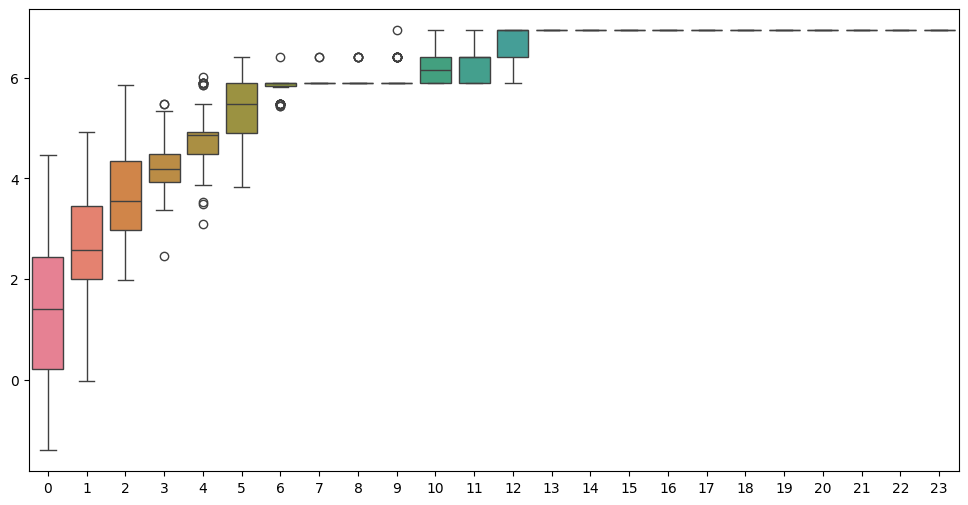

In [58]:
data = [x.to_numpy().flatten() for x in farm.history]
df = pd.DataFrame(data).T
# Create boxplot for each column (list)
plt.figure(figsize=(12, 6))  # Optional: You can set the figure size
sns.boxplot(data=df)
plt.show()


In [30]:
my_frames = farm.run_episodes(150,10)

episode 0 : actor loss - -25398.78515625 /// critic loss - [[1.6860805]]
episode 1 : actor loss - -1613.7620849609375 /// critic loss - [[0.00680475]]
episode 2 : actor loss - 20486.802734375 /// critic loss - [[1.0968742]]
episode 3 : actor loss - -20420.373046875 /// critic loss - [[1.0898353]]
episode 4 : actor loss - 22385.484375 /// critic loss - [[1.309699]]
episode 5 : actor loss - -15876.560546875 /// critic loss - [[0.6587833]]
episode 6 : actor loss - -5795.662109375 /// critic loss - [[0.08778878]]
episode 7 : actor loss - -4998.748046875 /// critic loss - [[0.06529123]]
episode 8 : actor loss - -2521.60107421875 /// critic loss - [[0.0166149]]
episode 9 : actor loss - 8567.142578125 /// critic loss - [[0.19182768]]
episode 10 : actor loss - 8409.833984375 /// critic loss - [[0.1848484]]
episode 11 : actor loss - 174.14828491210938 /// critic loss - [[7.926388e-05]]
episode 12 : actor loss - -17341.546875 /// critic loss - [[0.7859953]]
episode 13 : actor loss - 12699.655273

In [35]:
images = []
for filename in my_frames:
    images.append(imageio.imread(filename))
imageio.mimsave('training_animation.gif', images, loop=1)


/tmp/ipykernel_1590928/1119884689.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


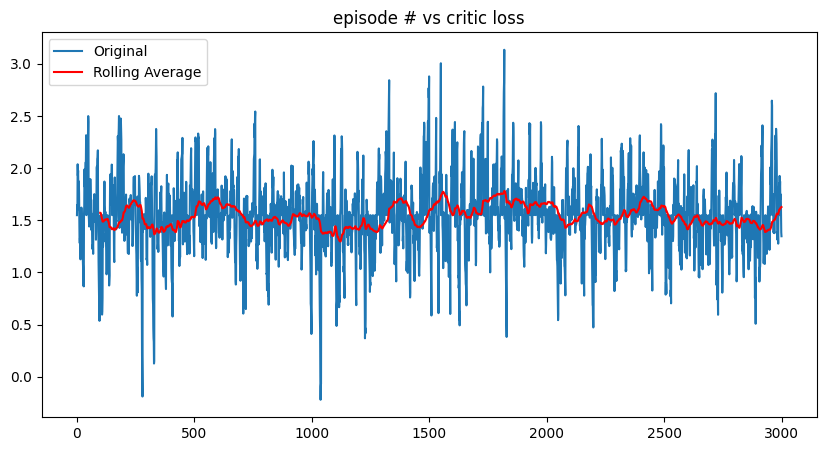

In [31]:
#average fitness for each episode
import matplotlib.pyplot as plt
import pandas as pd

# Assuming mean_score_list is a list containing your data
mean_score_series = pd.Series(mean_score_list)

# Calculate the rolling average
rolling_mean = mean_score_series.rolling(window=100).mean()

# Create the plot
plt.figure(figsize=(10, 5))
plt.plot(mean_score_series, label='Original')
plt.plot(rolling_mean, 'r-', label='Rolling Average')
plt.title("episode # vs critic loss")
plt.legend(loc='upper left')
plt.show()


In [18]:
# import imageio

# def create_video(frames, filename):
#     # Convert PIL Images to numpy arrays
#     numpy_frames = [np.array(img) for img in frames]

#     # Write frames to a video
#     imageio.mimsave(filename, numpy_frames, fps=2)  # Adjust fps (frames per second) as needed

# # frames = farm.run_episodes(100, 10)
# create_video(my_frames, 'training_animation.mp4')

In [ ]:
type(farm.history)

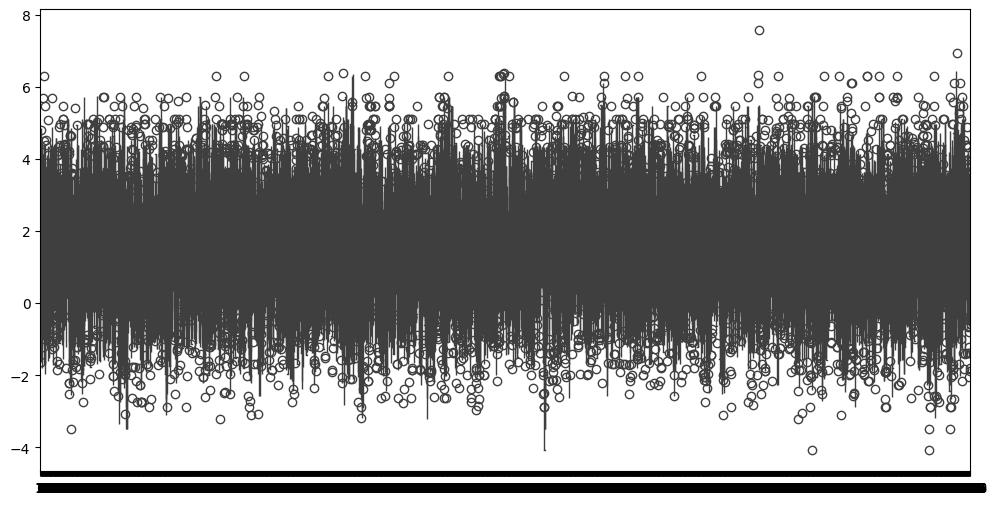

In [34]:
data = [x.to_numpy().flatten() for x in farm.history]
df = pd.DataFrame(data).T
# Create boxplot for each column (list)
plt.figure(figsize=(12, 6))  # Optional: You can set the figure size
sns.boxplot(data=df)
plt.show()


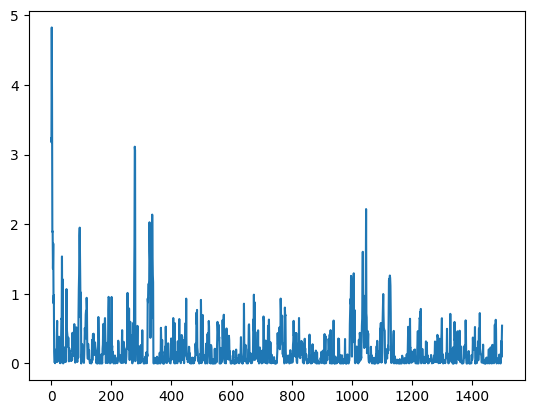

In [21]:
plt.plot(farm.critic_history)

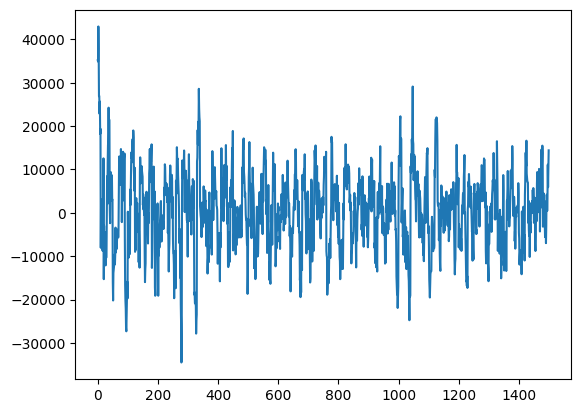

In [22]:
plt.plot(farm.actor_history)

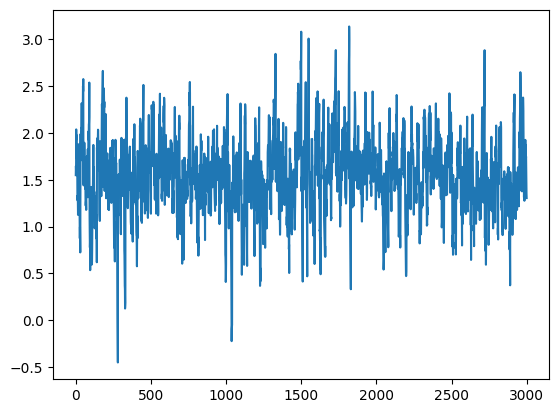

In [33]:
plt.plot([x.mean()[0] for x in farm.history])